In [1]:
import os
os.chdir('../..')

import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from utils import generate_random_pair, generate_constraints_stratified, transitive_closure, transitive_closure_new
from C_dec_trainer import Trainer
from model import DEC
from dataset import GeneralDataset, MLDataset, CLDataset
import random

SEED = random.randint(0, 2**32-1)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# prepare data
table = pd.read_csv('/home/haiping_liu/code/My_model/ImCluster/data/Damond_embedding.csv')
table.loc[table['cell type'] == 'acinar', 'cell type'] = 'exocrine'
table.loc[table['cell type'] == 'ductal', 'cell type'] = 'exocrine'
table = table[table['cell type'] != 'unknown']

data = table.iloc[:, 0:20].values
batch_id = table.iloc[:, 20].values
cell_type = table.iloc[:, 21].values

label_encoder = LabelEncoder()
cell_type = label_encoder.fit_transform(cell_type)
cell_type_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

num_constraints = 3000
ml_ind1, ml_ind2, cl_ind1, cl_ind2 = generate_random_pair(cell_type, num_constraints)
ml_ind1, ml_ind2, cl_ind1, cl_ind2 = transitive_closure(ml_ind1, ml_ind2, cl_ind1, cl_ind2, data.shape[0])

ml_ind1 = ml_ind1[:num_constraints]
ml_ind2 = ml_ind2[:num_constraints]
cl_ind1 = cl_ind1[:num_constraints]
cl_ind2 = cl_ind2[:num_constraints]

train_dataset = GeneralDataset(data, cell_type)
ml_dataset = MLDataset(ml_ind1, ml_ind2, data)
cl_dataset = CLDataset(cl_ind1, cl_ind2, data)

dec_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=256)
eva_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=256)
ml_dataloader = DataLoader(ml_dataset, shuffle=True, batch_size=128)
cl_dataloader = DataLoader(cl_dataset, shuffle=True, batch_size=128)

# build model
idea_model = DEC(input_dim=20, latent_dim=10, n_clusters=8)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
idea_model = idea_model.to(device)

trainable_params = list(filter(lambda p: p.requires_grad, idea_model.autoencoder.parameters())) 
pretrain_optimizer = torch.optim.Adam(trainable_params, lr=1e-4)
cluster_optimizer = torch.optim.Adam(idea_model.parameters(), lr=1e-4)

trainer = Trainer(idea_model, 
                    cluster_optimizer, 
                    pretrain_optimizer, 
                    dec_dataloader, 
                    ml_dataloader, 
                    cl_dataloader, 
                    eva_dataloader,
                    device)

trainer.train()
predicted_labels, true_labels, acc, ari, nmi = trainer.evaluate()

Pretraining finished
Initializing cluster centers with K-Means
K-Means初始化完成
1 pairwise train
1: ACC=0.4317, ARI=0.2040, NMI=0.3979
Change ratio: 100.00%
2 pairwise train
2: ACC=0.5731, ARI=0.3165, NMI=0.4387
Change ratio: 24.05%
3 pairwise train
3: ACC=0.6207, ARI=0.3874, NMI=0.4852
Change ratio: 9.50%
4 pairwise train
4: ACC=0.6137, ARI=0.3899, NMI=0.4843
Change ratio: 2.76%
5 pairwise train
5: ACC=0.6498, ARI=0.4324, NMI=0.4954
Change ratio: 6.50%
6 pairwise train
6: ACC=0.6661, ARI=0.4567, NMI=0.5009
Change ratio: 3.20%
7 pairwise train
7: ACC=0.6966, ARI=0.5002, NMI=0.5108
Change ratio: 4.12%
8 pairwise train
8: ACC=0.7196, ARI=0.5365, NMI=0.5191
Change ratio: 2.88%
9 pairwise train
9: ACC=0.7427, ARI=0.5806, NMI=0.5303
Change ratio: 3.33%
10 pairwise train
10: ACC=0.7654, ARI=0.6264, NMI=0.5392
Change ratio: 3.10%
11 pairwise train
11: ACC=0.7705, ARI=0.6431, NMI=0.5450
Change ratio: 1.55%
12 pairwise train
12: ACC=0.7928, ARI=0.6888, NMI=0.5559
Change ratio: 2.73%
13 pairwise tra

In [6]:
sample_indices = np.random.choice(data.shape[0], int(data.shape[0] * 0.02), replace=False)

data_sampled = data[sample_indices]
cell_type_sampled = cell_type[sample_indices]

ml_ind1, ml_ind2, cl_ind1, cl_ind2 = generate_random_pair(cell_type_sampled, 30)
ml_ind1, ml_ind2, cl_ind1, cl_ind2 = transitive_closure(ml_ind1, ml_ind2, cl_ind1, cl_ind2, data_sampled.shape[0])

sampled_dataset = GeneralDataset(data_sampled, cell_type_sampled)
sampled_dataloader = DataLoader(sampled_dataset, shuffle=False, batch_size=256)

idea_model.eval()
all_preds = []
all_labels = []
all_z = []

with torch.no_grad():
    for batch_data in sampled_dataloader:
        x, y = batch_data
        x = x.to(device)
        q, z, out = idea_model(x)  

        all_z.append(z.cpu().numpy())
        all_preds.append(q.cpu().numpy())
        all_labels.append(y.cpu().numpy())

preds = np.vstack(all_preds)
true_labels = np.concatenate(all_labels, axis=0)
embedding = np.vstack(all_z)

predicted_labels = np.argmax(preds, axis=1)

trainer.evaluate()


(array([2, 2, 2, ..., 2, 2, 2]),
 array([7, 7, 7, ..., 7, 7, 7]),
 0.8451974211332567,
 0.8485258316160722,
 0.6088480568184081)

/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


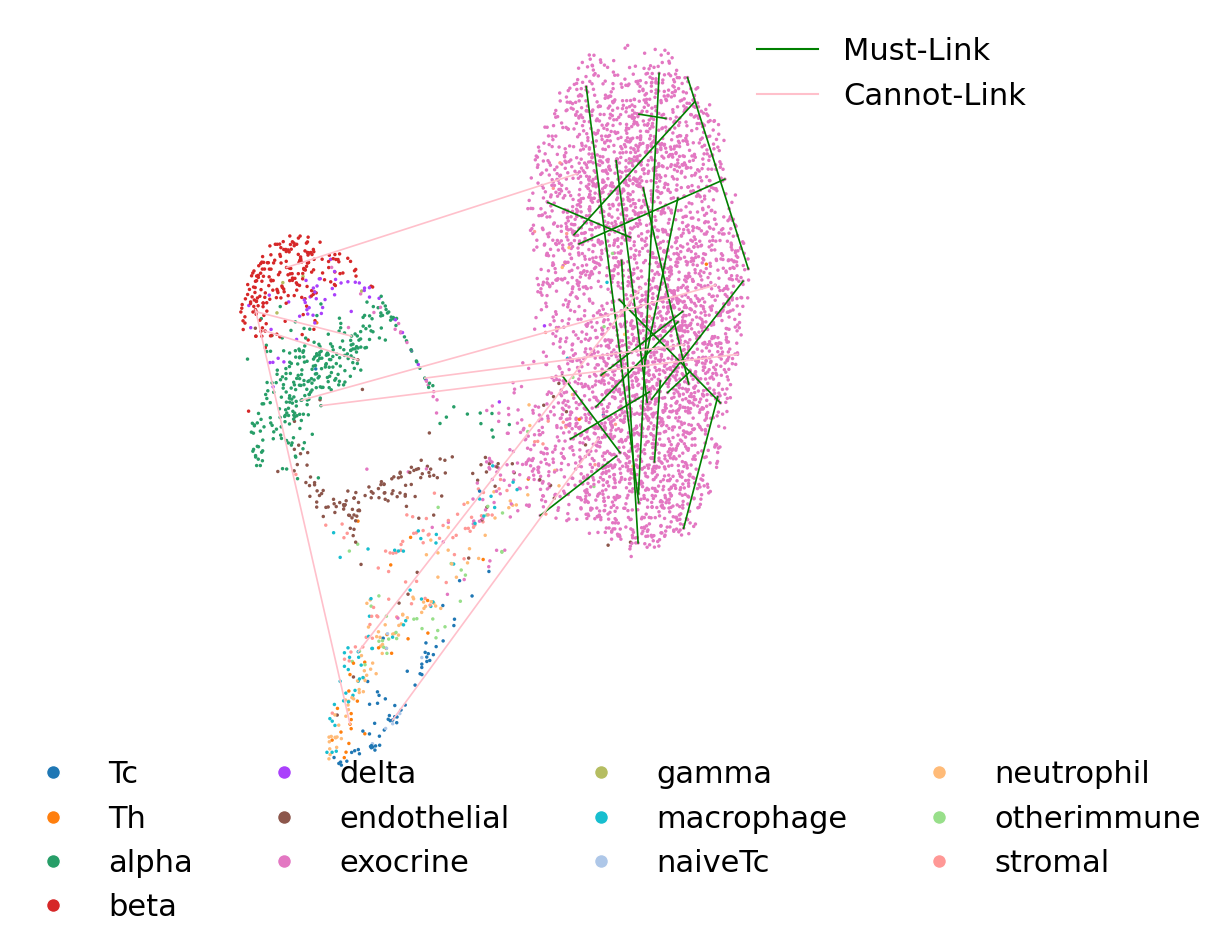

In [16]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 全局字体设置
plt.rcParams.update({'font.size': 22})

# 创建 adata 对象
adata = sc.AnnData(embedding)
adata.obs['preds'] = predicted_labels
adata.obs['celltype'] = [cell_type_mapping[i] for i in true_labels]
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# 创建绘图
fig, ax = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)

# 绘制 UMAP 图
sc.pl.umap(
    adata,
    color=['celltype'],
    frameon=False,
    ax=ax,
    show=False,
    title=""
)

# 绘制约束线
def plot_constraints(ax, adata, ml_ind1, ml_ind2, cl_ind1, cl_ind2):
    for i, j in zip(ml_ind1, ml_ind2):
        ax.plot(
            [adata.obsm['X_umap'][i, 0], adata.obsm['X_umap'][j, 0]],
            [adata.obsm['X_umap'][i, 1], adata.obsm['X_umap'][j, 1]],
            color='green', alpha=1, linewidth=1.2
        )
    for i, j in zip(cl_ind1, cl_ind2):
        ax.plot(
            [adata.obsm['X_umap'][i, 0], adata.obsm['X_umap'][j, 0]],
            [adata.obsm['X_umap'][i, 1], adata.obsm['X_umap'][j, 1]],
            color='pink', alpha=1, linewidth=1.2
        )

# 调用约束绘制函数
plot_constraints(ax, adata, ml_ind1, ml_ind2, cl_ind1, cl_ind2)

# 添加约束图例
constraint_legend = [
    Line2D([0], [0], color='green', lw=1.5, label='Must-Link'),
    Line2D([0], [0], color='pink', lw=1.5, label='Cannot-Link')
]

ax.legend(
    handles=constraint_legend,
    loc='upper right',
    bbox_to_anchor=(1.5,1), 
    frameon=False
)

# 创建 cell type 图例
# 获取 cell type 和对应的颜色
celltype_colors = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))

# 构建 cell type 图例
celltype_legend = [
    Line2D([0], [0], marker='o', color='w', label=cat,
           markerfacecolor=celltype_colors[cat], markersize=10)
    for cat in adata.obs['celltype'].cat.categories
]

# 添加到主图的下方
fig.legend(
    handles=celltype_legend,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=4,  # 每行显示 4 个类别
    frameon=False
)

# 设置标题
# fig.suptitle("IMMUcan", fontsize=20)

# 显示图形
plt.show()


/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


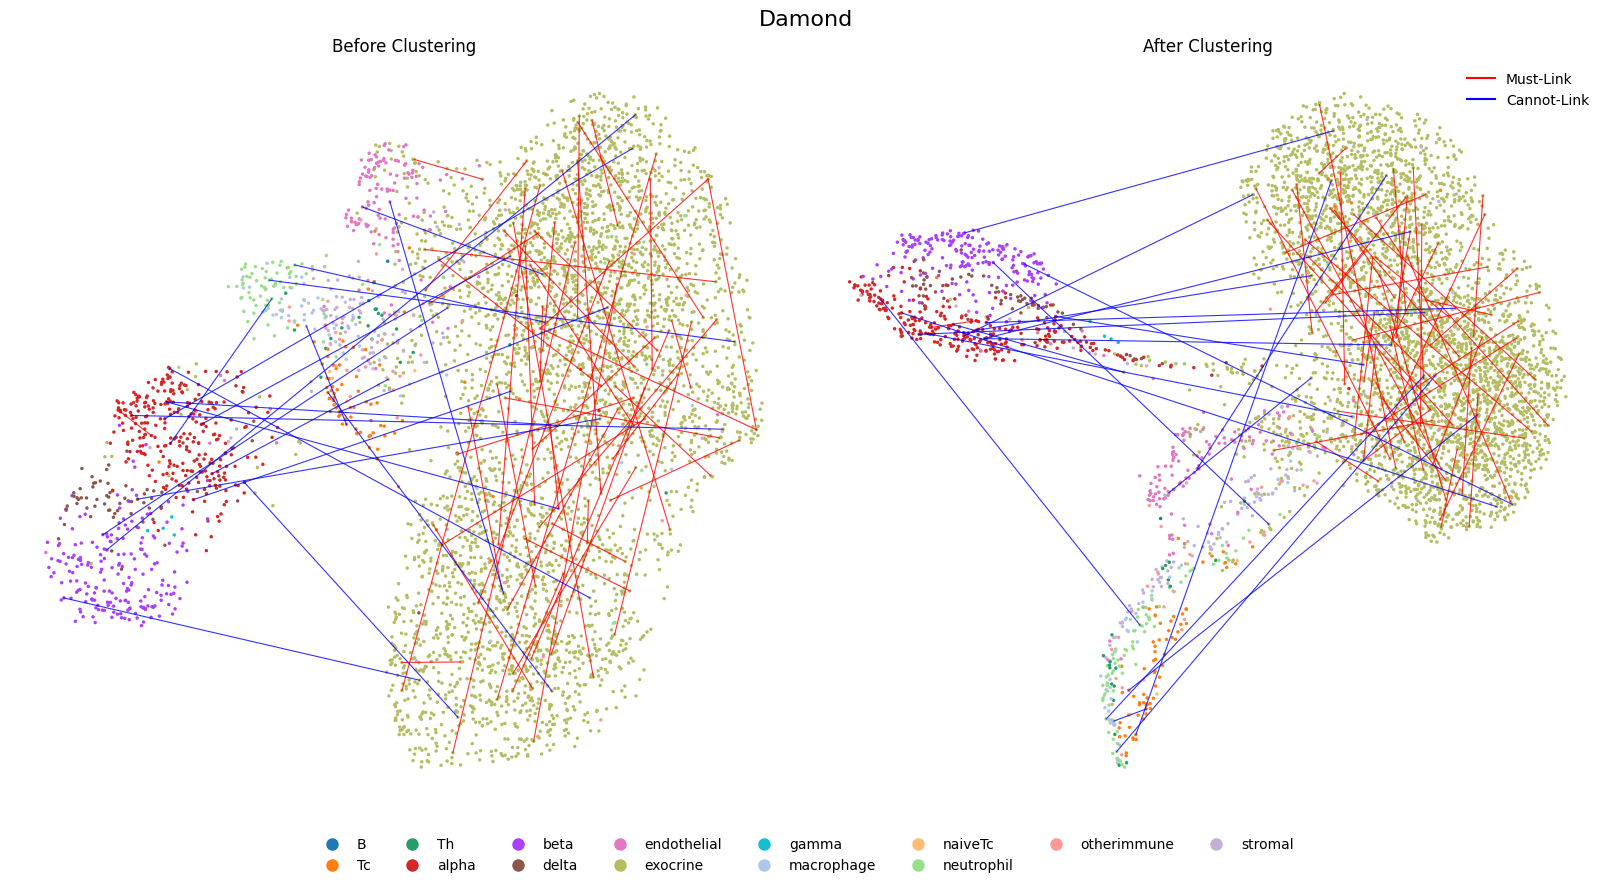

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 处理 adata_raw
adata_raw = sc.AnnData(data_sampled)
adata_raw.obs['celltype'] = [cell_type_mapping[i] for i in true_labels]
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)

# 处理 adata
adata = sc.AnnData(embedding)
adata.obs['preds'] = predicted_labels
adata.obs['celltype'] = [cell_type_mapping[i] for i in true_labels]
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# 创建左右平齐的子图
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

# 定义 Must-Link 和 Cannot-Link 连线绘制函数
def plot_constraints(ax, adata, ml_ind1, ml_ind2, cl_ind1, cl_ind2):
    for i, j in zip(ml_ind1, ml_ind2):
        ax.plot(
            [adata.obsm['X_umap'][i, 0], adata.obsm['X_umap'][j, 0]],
            [adata.obsm['X_umap'][i, 1], adata.obsm['X_umap'][j, 1]],
            color='red', alpha=0.8, linewidth=0.8
        )
    for i, j in zip(cl_ind1, cl_ind2):
        ax.plot(
            [adata.obsm['X_umap'][i, 0], adata.obsm['X_umap'][j, 0]],
            [adata.obsm['X_umap'][i, 1], adata.obsm['X_umap'][j, 1]],
            color='blue', alpha=0.8, linewidth=0.8
        )

# 绘制左图：adata_raw
sc.pl.umap(
    adata_raw,
    color=['celltype'],
    frameon=False,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title="Before Clustering"
)
plot_constraints(axes[0], adata_raw, ml_ind1, ml_ind2, cl_ind1, cl_ind2)  

# 绘制右图：adata
sc.pl.umap(
    adata,
    color=['celltype'],
    frameon=False,
    ax=axes[1],
    show=False,
    title="After Clustering"
)
plot_constraints(axes[1], adata, ml_ind1, ml_ind2, cl_ind1, cl_ind2)  

constraint_legend = [
    Line2D([0], [0], color='red', lw=1.5, label='Must-Link'),
    Line2D([0], [0], color='blue', lw=1.5, label='Cannot-Link')
]
axes[1].legend(
    handles=constraint_legend,
    loc='upper right',
    frameon=False
)

celltype_colors_raw = dict(zip(adata_raw.obs['celltype'].cat.categories, adata_raw.uns['celltype_colors']))
celltype_colors = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))


celltype_legend = [
    Line2D([0], [0], marker='o', color='w', label=cat, 
           markerfacecolor=celltype_colors[cat], markersize=10)
    for cat in adata.obs['celltype'].cat.categories
]

fig.legend(
    celltype_legend,
    [h.get_label() for h in celltype_legend],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=8,
    frameon=False
)
fig.suptitle("Damond", fontsize=16)
plt.show()


In [ ]:
from utils import visualize
embeddings, labels = trainer.get_embedding()
sampling_ratio = 0.1

sample_size = int(len(labels) * sampling_ratio)
sample_indices = np.random.choice(len(labels), sample_size, replace=False)
sampled_embeddings = embeddings[sample_indices]
sampled_labels = labels[sample_indices]

centers = trainer.initialize_clusters()
visualize(sampled_embeddings, sampled_labels, centers)

In [2]:
idea_model.eval()
all_preds = []
all_labels = []
all_z = []

with torch.no_grad():
    for batch_data in dec_dataloader:
        x, y = batch_data
        x = x.to(device)
        q, z, out = idea_model(x)

        all_z.append(z.cpu().numpy())
        all_preds.append(q.cpu().numpy())
        all_labels.append(y.cpu().numpy())

preds = np.vstack(all_preds)
true_labels = np.concatenate(all_labels, axis=0)
embedding = np.vstack(all_z)

# Predict cluster assignments
predicted_labels = np.argmax(preds, axis=1)

/root/miniconda3/envs/idea/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


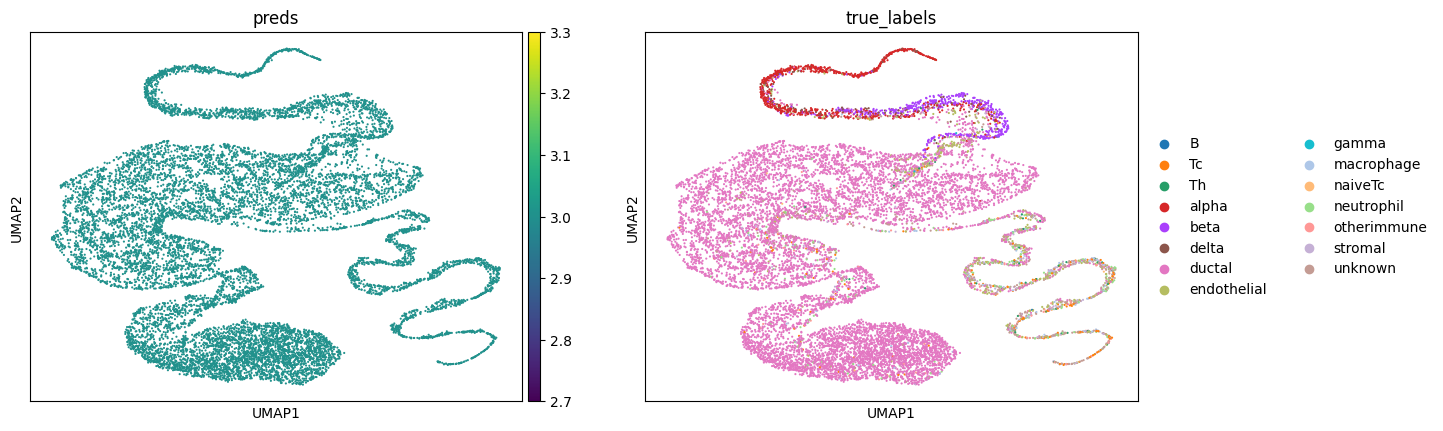

In [3]:
import scanpy as sc

adata = sc.AnnData(embedding)
adata.obs['preds'] = predicted_labels
true_labels = [cell_type_mapping[i] for i in true_labels]
adata.obs['true_labels'] = true_labels
sc.pp.subsample(adata, fraction=0.05)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['preds', 'true_labels'])